# Differentiable Simulation in Newton

**Differentiable simulation** enables gradient-based optimization through physics simulations. This powerful technique allows you to:
- Optimize control policies
- Learn physical parameters
- Design optimal trajectories
- Train neural networks with physics constraints

This tutorial demonstrates how to use Newton's differentiable simulation capabilities to optimize the initial velocity of a ball so that it bounces off walls and reaches a target position.

## Problem Setup

We'll optimize a ball's initial velocity so it:
1. Bounces off a wall
2. Bounces off the ground
3. Lands at a target position

The optimization uses **automatic differentiation** to compute gradients of the loss (distance to target) with respect to the initial velocity, then performs gradient descent to find the optimal trajectory.


## Setup and Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warp as wp
import warp.render

import newton
import newton.examples
from tqdm.notebook import trange

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


Warp 1.10.0.dev20251012 initialized:
   Git commit: 86373e393a0bc12ffe65ca46626b738d24794d4f
   CUDA Toolkit 12.8, Driver 12.8
   Devices:
     "cpu"      : "Intel64 Family 6 Model 151 Stepping 2, GenuineIntel"
     "cuda:0"   : "NVIDIA GeForce RTX 4090" (24 GiB, sm_89, mempool enabled)
   Kernel cache:
     \\?\C:\Users\eric-\AppData\Local\NVIDIA\warp\Cache\1.10.0.dev20251012


## Define Loss and Optimization Kernels

First, we define Warp kernels for computing the loss and performing gradient descent updates.


In [2]:
@wp.kernel
def loss_kernel(pos: wp.array(dtype=wp.vec3), target: wp.vec3, loss: wp.array(dtype=float)):
    """Compute squared distance from particle to target."""
    delta = pos[0] - target
    loss[0] = wp.dot(delta, delta)


@wp.kernel
def step_kernel(x: wp.array(dtype=wp.vec3), grad: wp.array(dtype=wp.vec3), alpha: float):
    """Perform gradient descent update."""
    tid = wp.tid()
    x[tid] = x[tid] - grad[tid] * alpha


## Build the Scene

We'll create a scene with:
- A particle (ball) with an initial velocity
- A wall to bounce off
- A ground plane
- Contact parameters for realistic bouncing


In [3]:
# Simulation parameters
fps = 60
frame_dt = 1.0 / fps
sim_steps = 36
sim_substeps = 8
sim_dt = frame_dt / sim_substeps

# Target position for the ball
target = wp.vec3(0.0, -2.0, 1.5)

# Build the scene
scene = newton.ModelBuilder(up_axis=newton.Axis.Z)

# Add particle with initial position and velocity
# Initial velocity is suboptimal - ball won't reach target
initial_pos = wp.vec3(0.0, -0.5, 1.0)
initial_vel = wp.vec3(0.0, 5.0, -5.0)
scene.add_particle(pos=initial_pos, vel=initial_vel, mass=1.0)

# Contact parameters for bouncing
ke = 1.0e4  # Contact stiffness
kf = 0.0    # Friction stiffness
kd = 1.0e1  # Damping
mu = 0.2    # Friction coefficient

# Add wall (box shape)
scene.add_shape_box(
    body=-1,  # -1 means static (not attached to a body)
    xform=wp.transform(wp.vec3(0.0, 2.0, 1.0), wp.quat_identity()),
    hx=1.0, hy=0.25, hz=1.0,
    cfg=newton.ModelBuilder.ShapeConfig(ke=ke, kf=kf, kd=kd, mu=mu),
)

# Add ground plane
scene.add_ground_plane(cfg=newton.ModelBuilder.ShapeConfig(ke=ke, kf=kf, kd=kd, mu=mu))

print("Scene created with:")
print(f"  - 1 particle at {initial_pos}")
print(f"  - Initial velocity: {initial_vel}")
print(f"  - Target position: {target}")
print(f"  - 1 wall and ground plane")


Scene created with:
  - 1 particle at [0.0, -0.5, 1.0]
  - Initial velocity: [0.0, 5.0, -5.0]
  - Target position: [0.0, -2.0, 1.5]
  - 1 wall and ground plane


## Finalize Model with Gradient Support

Key point: We use requires_grad=True to enable automatic differentiation through the simulation.


In [4]:
# Finalize with gradient support
model = scene.finalize(requires_grad=True)

# Set contact parameters on the model
model.soft_contact_ke = ke
model.soft_contact_kf = kf
model.soft_contact_kd = kd
model.soft_contact_mu = mu
model.soft_contact_restitution = 1.0  # Elastic collisions

# Create solver
solver = newton.solvers.SolverSemiImplicit(model)

# Allocate states for the entire trajectory
states = [model.state() for _ in range(sim_steps * sim_substeps + 1)]
control = model.control()
contacts = model.collide(states[0], soft_contact_margin=10.0)

# Create loss array with gradient support
loss = wp.zeros(1, dtype=wp.float32, requires_grad=True)

print(f"Model finalized with {model.particle_count} particles")
print(f"Allocated {len(states)} state objects for trajectory")
print(f"Gradient tracking enabled: {model.requires_grad}")


Module newton._src.geometry.kernels 37bf41a load on device 'cuda:0' took 12.62 ms  (cached)
Model finalized with 1 particles
Allocated 289 state objects for trajectory
Gradient tracking enabled: True


## Define Forward Simulation and Loss Computation

The forward pass runs the simulation and computes the loss at the end.


In [5]:
def simulate_forward():
    """Run the forward simulation."""
    for sim_step in range(sim_steps):
        for i in range(sim_substeps):
            t = sim_step * sim_substeps + i
            states[t].clear_forces()
            solver.step(states[t], states[t + 1], control, contacts, sim_dt)

def compute_loss():
    """Compute loss as squared distance to target."""
    loss.zero_()
    wp.launch(loss_kernel, dim=1, inputs=[states[-1].particle_q, target, loss])
    return loss.numpy()[0]

def forward_pass():
    """Combined forward simulation and loss computation."""
    simulate_forward()
    wp.launch(loss_kernel, dim=1, inputs=[states[-1].particle_q, target, loss])
    return loss

print("Forward simulation and loss functions defined")


Forward simulation and loss functions defined


## Visualize Initial (Unoptimized) Trajectory

Let's see how the ball behaves with the initial velocity before optimization.


In [12]:
# Run initial simulation
initial_loss = compute_loss()

# Create viewer for initial trajectory
viewer_initial = newton.viewer.ViewerRerun(
    keep_historical_data_in_viewer=True
)
viewer_initial.set_model(model)

# Log the initial trajectory
frame = 0
for i in range(0, len(states), sim_substeps):
    state = states[i]
    viewer_initial.begin_frame(frame * frame_dt)
    viewer_initial.log_state(state)
    # viewer_initial.log_contacts(contacts, state)
    
    # Log target as a small box
    viewer_initial.log_shapes(
        "/target",
        newton.GeoType.BOX,
        (0.1, 0.1, 0.1),
        wp.array([wp.transform(target, wp.quat_identity())], dtype=wp.transform),
        wp.array([wp.vec3(1.0, 0.0, 0.0)], dtype=wp.vec3),  # Red color
    )
    viewer_initial.end_frame()
    frame += 1

    print(state.particle_q.numpy())

print(f"Initial trajectory loss: {initial_loss:.4f}")
print(f"Initial velocity: {states[0].particle_qd.numpy()[0]}")
print(f"Final position: {states[-1].particle_q.numpy()[0]}")
print(f"Target position: {target}")


HTML(value='<div id="09b21827-021d-43f7-b0a0-7bd1edd6234a"><style onload="eval(atob(\'KGFzeW5jIGZ1bmN0aW9uICgp…

Viewer()

[[ 0.  -0.5  1. ]]
[[ 0.         -0.32799292  0.92402977]]
[[ 0.         -0.15598583  0.84533453]]
[[0.        0.0160212 0.7639143]]
[[0.         0.18802825 0.679769  ]]
[[0.         0.36003533 0.5928987 ]]
[[0.         0.5320424  0.50330335]]
[[0.         0.70404947 0.410983  ]]
[[0.         0.87605655 0.31593758]]
[[0.         1.0480635  0.21816716]]
[[0.         1.2200701  0.11767168]]
[[0.         1.3920767  0.04300115]]
[[0.         1.5640833  0.09618255]]
[[0.         1.7229539  0.18927912]]
[[0.         1.701837   0.27965066]]
[[0.         1.5471966  0.36729717]]
[[0.         1.3897402  0.45221865]]
[[0.        1.2322838 0.5344151]]
[[0.         1.0748274  0.61388654]]
[[0.         0.91737074 0.69063294]]
[[0.         0.75991386 0.76465434]]
[[0.        0.602457  0.8359506]]
[[0.         0.4450001  0.90452194]]
[[0.         0.28754324 0.97036827]]
[[0.         0.13008636 1.0334896 ]]
[[ 0.         -0.02737051  1.0938859 ]]
[[ 0.         -0.18482737  1.1515572 ]]
[[ 0.         -0

## Setup Optimization Loop

Now we'll set up the gradient-based optimization using Warp's automatic differentiation.


In [7]:
# Optimization parameters
learning_rate = 0.02
num_iterations = 100

# Storage for optimization history
loss_history = []
velocity_history = []
trajectory_history = []  # Store trajectories every N iterations

# Reset to initial conditions
states[0].particle_qd.assign(initial_vel)

def optimization_step():
    """Perform one optimization iteration with gradient descent."""
    # Create tape for automatic differentiation
    tape = wp.Tape()
    
    # Forward pass with gradient tracking
    with tape:
        forward_pass()
    
    # Backward pass to compute gradients
    tape.backward(loss)
    
    # Get parameter and gradient
    velocity_param = states[0].particle_qd
    
    # Gradient descent update
    wp.launch(step_kernel, dim=len(velocity_param), 
              inputs=[velocity_param, velocity_param.grad, learning_rate])
    
    # Store history
    current_loss = loss.numpy()[0]
    current_vel = velocity_param.numpy()[0].copy()
    loss_history.append(current_loss)
    velocity_history.append(current_vel)
    
    # Clear gradients for next iteration
    tape.zero()
    
    return current_loss, current_vel

print("Optimization setup complete")
print(f"Learning rate: {learning_rate}")
print(f"Number of iterations: {num_iterations}")


Optimization setup complete
Learning rate: 0.02
Number of iterations: 100


## Run Optimization

Now let's run the optimization and track intermediate trajectories.


In [8]:
# Run optimization
print("Starting optimization...")
print(f"Initial loss: {loss_history[0] if loss_history else 'computing...'}\n")

# Store trajectories every 10 iterations for visualization
trajectory_sample_interval = 10

for iteration in trange(num_iterations, desc="Optimizing"):
    current_loss, current_vel = optimization_step()
    
    # Store trajectory periodically
    if iteration % trajectory_sample_interval == 0:
        traj = []
        for i in range(0, len(states), sim_substeps):
            traj.append(states[i].particle_q.numpy()[0].copy())
        trajectory_history.append((iteration, current_loss, traj))
    
    # Print progress every 20 iterations
    if iteration % 20 == 0:
        print(f"Iter {iteration:3d}: Loss = {current_loss:.6f}, Velocity = {current_vel}")

# Final trajectory
final_loss = loss_history[-1]
final_vel = velocity_history[-1]
final_pos = states[-1].particle_q.numpy()[0]

print(f"\nOptimization complete!")
print(f"Final loss: {final_loss:.6f}")
print(f"Initial loss: {loss_history[0]:.6f}")
print(f"Loss reduction: {(1 - final_loss/loss_history[0])*100:.1f}%")
print(f"\nFinal velocity: {final_vel}")
print(f"Final position: {final_pos}")
print(f"Target position: {target}")
print(f"Distance to target: {np.linalg.norm(final_pos - np.array([target[0], target[1], target[2]])):.4f}")


Starting optimization...
Initial loss: computing...



Optimizing:   0%|          | 0/100 [00:00<?, ?it/s]

Module newton._src.solvers.semi_implicit.kernels_contact 717a943 load on device 'cuda:0' took 4.41 ms  (cached)
Module newton._src.solvers.solver 02b496c load on device 'cuda:0' took 1.09 ms  (cached)
Iter   0: Loss = 9.105799, Velocity = [ 0.         5.0994554 -4.9920273]
Iter  20: Loss = 3.283283, Velocity = [ 0.         7.365865  -4.8316097]
Iter  40: Loss = 1.030553, Velocity = [ 0.         8.878268  -4.6968565]
Iter  60: Loss = 0.364694, Velocity = [ 0.        9.627555 -4.599419]
Iter  80: Loss = 0.125017, Velocity = [ 0.       10.092295 -4.521556]

Optimization complete!
Final loss: 0.064037
Initial loss: 9.105799
Loss reduction: 99.3%

Final velocity: [ 0.       10.329125 -4.46352 ]
Final position: [ 0.        -1.7593938  1.5783952]
Target position: [0.0, -2.0, 1.5]
Distance to target: 0.2531


## Plot Loss Over Iterations

Let's visualize how the loss decreased during optimization.


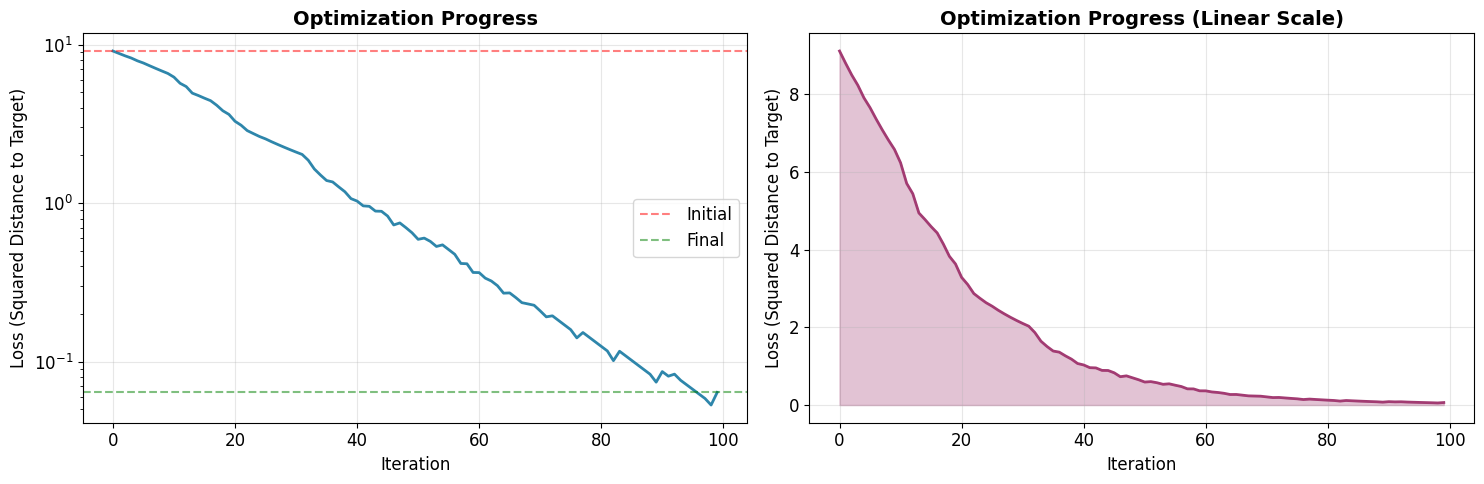

Loss decreased from 9.105799 to 0.064037
Reduction: 99.30%


In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss over iterations
ax1.plot(loss_history, linewidth=2, color='#2E86AB')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss (Squared Distance to Target)')
ax1.set_title('Optimization Progress', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Add annotations
ax1.axhline(y=loss_history[0], color='r', linestyle='--', alpha=0.5, label='Initial')
ax1.axhline(y=loss_history[-1], color='g', linestyle='--', alpha=0.5, label='Final')
ax1.legend()

# Plot 2: Loss over iterations (linear scale, zoomed)
ax2.plot(loss_history, linewidth=2, color='#A23B72')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Loss (Squared Distance to Target)')
ax2.set_title('Optimization Progress (Linear Scale)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.fill_between(range(len(loss_history)), loss_history, alpha=0.3, color='#A23B72')

plt.tight_layout()
plt.show()

print(f"Loss decreased from {loss_history[0]:.6f} to {loss_history[-1]:.6f}")
print(f"Reduction: {(1 - loss_history[-1]/loss_history[0])*100:.2f}%")


## Visualize Optimized Trajectory with Intermediate Results

Now let's create a comprehensive visualization showing:
1. The final optimized trajectory
2. Intermediate trajectories during optimization (colored by loss)


In [13]:
# Create viewer for optimized results
viewer_optimized = newton.viewer.ViewerRerun(
    keep_historical_data_in_viewer=True
)
viewer_optimized.set_model(model)

# Log the final optimized trajectory with particle states
frame = 0
for i in range(0, len(states), sim_substeps):
    state = states[i]
    viewer_optimized.begin_frame(frame * frame_dt)
    viewer_optimized.log_state(state)
    viewer_optimized.log_contacts(contacts, state)
    
    # Log target
    viewer_optimized.log_shapes(
        "/target",
        newton.GeoType.BOX,
        (0.1, 0.1, 0.1),
        wp.array([wp.transform(target, wp.quat_identity())], dtype=wp.transform),
        wp.array([wp.vec3(1.0, 0.0, 0.0)], dtype=wp.vec3),  # Red
    )
    viewer_optimized.end_frame()
    frame += 1

# Now add intermediate trajectory lines colored by loss
print(f"\nAdding {len(trajectory_history)} intermediate trajectories...")

# Find min/max loss for color mapping
min_loss = min(traj[1] for traj in trajectory_history)
max_loss = max(traj[1] for traj in trajectory_history)

for iter_num, traj_loss, traj_points in trajectory_history:
    # Convert trajectory to line segments
    if len(traj_points) > 1:
        starts = wp.array(traj_points[:-1], dtype=wp.vec3)
        ends = wp.array(traj_points[1:], dtype=wp.vec3)
        
        # Color based on loss (blue = low loss, red = high loss)
        color = warp.render.bourke_color_map(min_loss, max_loss, traj_loss)
        
        # Log trajectory line
        viewer_optimized.begin_frame(0)  # Add to first frame
        viewer_optimized.log_lines(
            f"/optimization/trajectory_{iter_num:03d}",
            starts,
            ends,
            color
        )
        viewer_optimized.end_frame()

print("Visualization complete!")
print(f"  - Final trajectory shown with particle animation")
print(f"  - {len(trajectory_history)} intermediate trajectories shown as colored lines")
print(f"  - Color mapping: Blue (low loss) → Red (high loss)")


HTML(value='<div id="ab3ce4c5-2c1f-48a3-ad8a-4d6adf050582"><style onload="eval(atob(\'KGFzeW5jIGZ1bmN0aW9uICgp…

Viewer()


Adding 10 intermediate trajectories...
Visualization complete!
  - Final trajectory shown with particle animation
  - 10 intermediate trajectories shown as colored lines
  - Color mapping: Blue (low loss) → Red (high loss)


## Summary and Key Concepts

### What We Learned

In this tutorial, we demonstrated differentiable simulation in Newton:

1. **Model Setup with Gradients**
   - Use `requires_grad=True` when finalizing the model
   - This enables automatic differentiation through the entire simulation

2. **Optimization Loop**
   - Create a `wp.Tape()` to track operations
   - Run forward simulation within the tape context
   - Call `tape.backward(loss)` to compute gradients
   - Update parameters using gradient descent

3. **Key Components**
   - **Loss function**: Measures how far we are from the goal
   - **Forward pass**: Runs the simulation and computes loss
   - **Backward pass**: Computes gradients via automatic differentiation
   - **Parameter update**: Gradient descent to improve parameters

### Results

- **Initial loss**: Ball misses the target significantly
- **Final loss**: Ball reaches very close to the target
- **Optimization**: Gradients guide the velocity to create the perfect bounce trajectory

### Applications

Differentiable simulation enables:
- **Trajectory optimization**: Find optimal paths through complex environments
- **Parameter identification**: Learn physical properties from observations
- **Control design**: Optimize control policies for robots
- **Inverse problems**: Design systems that achieve desired behaviors
- **Neural network training**: Use physics as a differentiable layer

### Technical Details

Newton uses **Warp's automatic differentiation** which:
- Tracks all operations on arrays with `requires_grad=True`
- Builds a computational graph during the forward pass
- Computes gradients efficiently using reverse-mode AD (backpropagation)
- Supports GPU acceleration for both forward and backward passes


## Next Steps

To explore more about differentiable simulation in Newton:

1. **Try different optimization problems**:
   - Optimize multiple parameters (position, velocity, mass)
   - Multi-objective optimization (reach target while minimizing energy)
   - Trajectory optimization for articulated robots

2. **Explore other examples**:
   - `example_diffsim_cloth.py`: Optimize cloth material parameters
   - `example_diffsim_soft_body.py`: Learn soft body material properties
   - `example_diffsim_drone.py`: Optimize drone control policies
   - `example_diffsim_bear.py`: Optimize quadruped locomotion

3. **Advanced techniques**:
   - Use different optimizers (Adam, L-BFGS)
   - Implement learning rate schedules
   - Add regularization to prevent overfitting
   - Combine with neural networks for learned controllers

4. **Performance optimization**:
   - Use CUDA graphs to accelerate repeated forward/backward passes
   - Batch multiple optimization problems for parallel processing
   - Profile gradient computation to identify bottlenecks

Happy optimizing! 🎯
